In [13]:
import os  
import cv2

**CODE WAS BUILD IN PYTHON 3.9.6**

In [16]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib

THIS CODE IS ONLY USE FOR DOWLOADING AND LABELING DATA DO NOT RE_USE IF WE HAVE ALREADY DOWLOADED!!!!!!!!!!

In [17]:
os.makedirs('./CRDD2022_all_countries', exist_ok=True)

In [19]:
ALL_2022 = {'Japan': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_Japan.zip',
            'India': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_India.zip',
            'Czech': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_Czech.zip',
            'Norway': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_Norway.zip',
            'United_States': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_United_States.zip',
            'China_MotorBike': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_China_MotorBike.zip',
            'China_Drone': 'https://bigdatacup.s3.ap-northeast-1.amazonaws.com/2022/CRDDC2022/RDD2022/Country_Specific_Data_CRDDC2022/RDD2022_China_Drone.zip'}

import urllib.request
from tqdm import tqdm
print('Dowload Stage')
for country_name, url in tqdm(ALL_2022.items()):
    urllib.request.urlretrieve(url, f'./CRDD2022_all_countries/{country_name}.zip')

Dowload Stage


100%|████████████████████████████████████████████| 7/7 [46:38<00:00, 399.83s/it]


In [20]:
import zipfile 
import shutil
all_file = "Collect_File/"

In [22]:
#unzip all of the file
os.makedirs('./Collect_File',exist_ok=True)
dict = "CRDD2022_all_countries/"

for file in os.listdir(dict): 
    file_path = os.path.join(dict,file) 

    if file.endswith(".zip"): 
        with zipfile.ZipFile(file_path,"r") as zip: 
            zip.extractall("Collect_File")
            print(f"file {file} have been unzip")

file China_MotorBike.zip have been unzip
file Czech.zip have been unzip
file China_Drone.zip have been unzip
file Japan.zip have been unzip
file United_States.zip have been unzip
file Norway.zip have been unzip
file India.zip have been unzip


In [26]:
import os 
import sys
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as pt
import tqdm
import pandas as pd

In [28]:
def get_all_xml():
    _allFILE = "Collect_File/"
#   get_and_STOREDATA
    _all_test = { 
        "file_name": [],
        "images": [], 
        "height": [],
        "width": [], 
        "detect": [], 
    } 
    
    stats = {
        'x': [], 
        'y': [], 
        'h': [], 
        'w': [], 
        
    }

    _trial_value = {
        "images": [],
        "type": []
    }

    for _allnameFILE in os.listdir(_allFILE): 
        _allnameFILElink = os.path.join(_allFILE,_allnameFILE + "/train/annotations/xmls") 
        print(f"FILE {_allnameFILE} loading...")

        for _allfile in os.listdir(_allnameFILElink):
            __xmlfile = os.path.join(_allnameFILElink,_allfile) 
            tree = ET.parse(__xmlfile)

            #   made file name... 
            _all_test["file_name"].append(_allnameFILE) 
            _all_test["images"].append(tree.find("filename").text) 
            _all_test["height"].append(int(tree.find("size").find("height").text))
            _all_test["width"].append(int(tree.find("size").find("width").text))

            _tmp = []

            
            #   add for all of the object that is valid for all the detections
            for object in tree.findall("object"):
                _type = object.find("name").text
                bbox = object.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)
                x_center = (float(xmin + xmax) / 2) / _all_test["width"][-1]
                y_center = (float(ymin + ymax) / 2) / _all_test["height"][-1]
                w = (xmax - xmin) / _all_test["width"][-1]
                h = (ymax - ymin) / _all_test["height"][-1]
                
                stats["x"].append(x_center) 
                stats["y"].append(y_center) 
                stats["h"].append(h)
                stats["w"].append(w)
                
                
                obj = {
                    "type": _type, 
                    "x": x_center, 
                    "y": y_center, 
                    "w": w, 
                    "h": h,
                }

                if _type not in _trial_value["type"]:
                    _trial_value["images"].append(_all_test["images"][-1])
                    _trial_value["type"].append(_type)

                _tmp.append(obj) 

            _all_test["detect"].append(_tmp)
    
    return _all_test,_trial_value, stats

In [29]:
def get_img(file_name,train):
    _type = file_name.split('_')[0]
    _next = file_name.split('_')[1]
    if _type == "China" or _type == "United":
        _type = _type + '_' + _next
    path = f"Collect_File/{_type}/{train}/images/{file_name}"
    try:
        img = cv2.imread(path)
    except:
        print(f"file {file_name} is not found !") 
    return img 

In [30]:
def show_img(file_name,_all_tests):
    img = get_img(file_name,"train")
    fig,ax = plt.subplots()
    ax.imshow(img)

    index = _all_tests["images"].index(file_name)
    
    # Draw boxes
    _BOXES = _all_tests["detect"][index]
    h = _all_tests["height"][index]
    w = _all_tests["width"][index]

    for _BOX in _BOXES:
        x_start = w * (_BOX["x"] - _BOX["w"] / 2) 
        y_start = h * (_BOX["y"] - _BOX["h"] / 2)

        rectangle = pt.Rectangle(
            (x_start, y_start), _BOX["w"]*w, _BOX["h"]*h,
            linewidth=2, edgecolor='blue', facecolor='none'
        )
        ax.add_patch(rectangle)
        ax.text(x_start, y_start - 5, _BOX["type"], color='blue', fontsize=10, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title(file_name)
    plt.grid()
    plt.show()

PRINT MODEL TESTING

In [31]:
#   Have to use this
_allXML,trial, stats = get_all_xml()

FILE Czech loading...
FILE Norway loading...
FILE China_Drone loading...
FILE United_States loading...
FILE India loading...
FILE China_MotorBike loading...
FILE Japan loading...


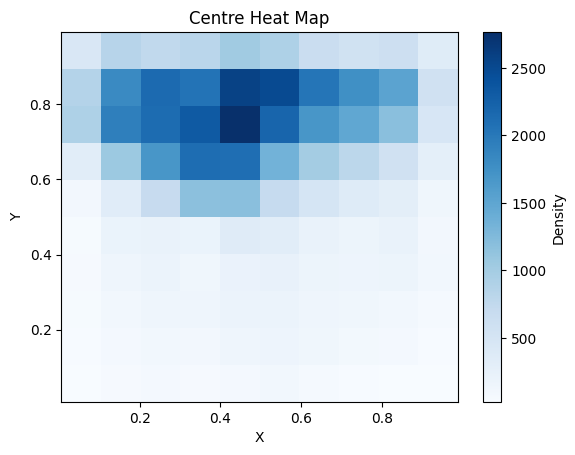

In [ ]:
# plot the heatmap for the centre 
plt.hist2d(stats['x'],stats['y'],cmap = 'Blues')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')Notebook Downloads/Capstone-Project---Asphalt-main/Asphalt Detection.ipynb is not trusted

plt.title('Centre Heat Map')
plt.show()  

{'type': 'D00', 'x': 0.4244166895415866, 'y': 0.7871876531112201, 'w': 0.059044743343398334, 'h': 0.4158255756981872}


KeyError: 'Repair'

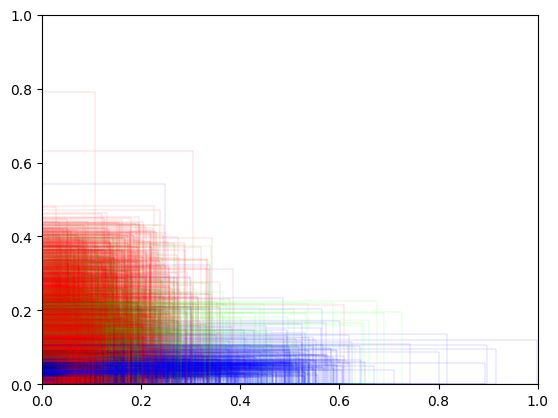

In [ ]:
color = {
    "D00": (1.0, 0.0, 0.0, 1.0),  # Red with full opacity
    "D10": (0.0, 0.0, 1.0, 1.0),  # Blue with full opacity
    "D20": (0.0, 1.0, 0.0, 1.0),  # Yellow with full opacity
    "D40": (0.0, 0.0, 0.0, 1.0),  # Black with full opacity
}

fig,ax = plt.subplots() 
bboxss = _allXML['detect']
print(bboxss[1][0])



for bboxs in bboxss:
    for bbox in bboxs:  
        type = bbox['type']
        rec = pt.Rectangle(
            (0,0), 
            bbox['w'],Notebook Downloads/Capstone-Project---Asphalt-main/Asphalt Detection.ipynb is not trusted

            bbox['h'],  
            linewidth=0.1, edgecolor=color[type], facecolor='none',
            fill=False   
        )
        ax.add_patch(rec)   
        
 
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axis('off')

# Show the plot
plt.show() 


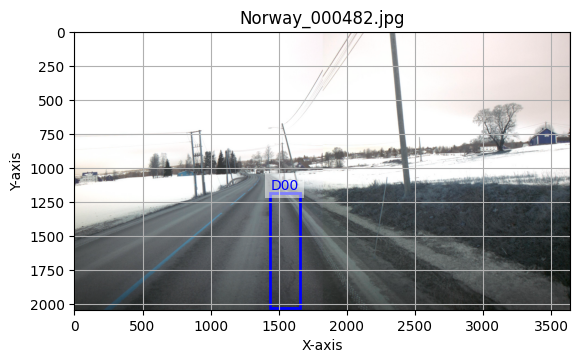

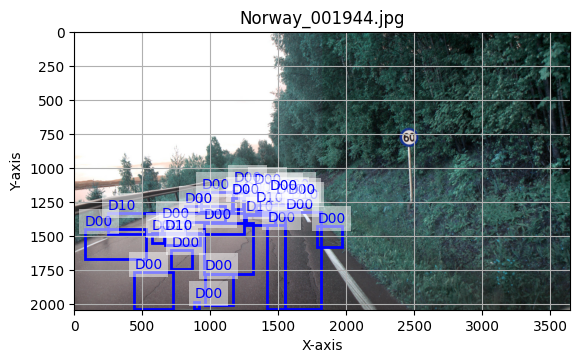

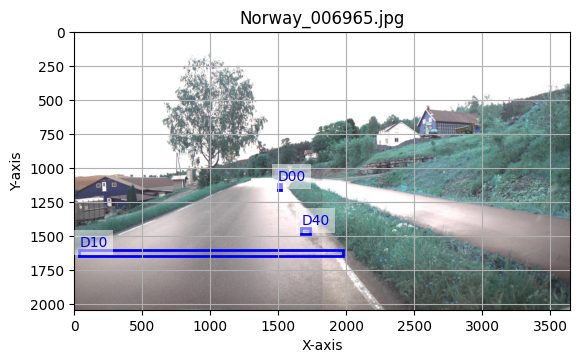

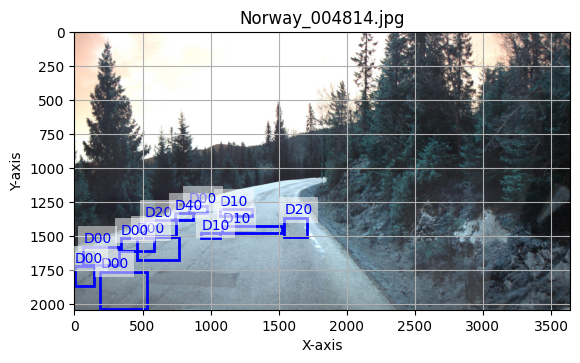

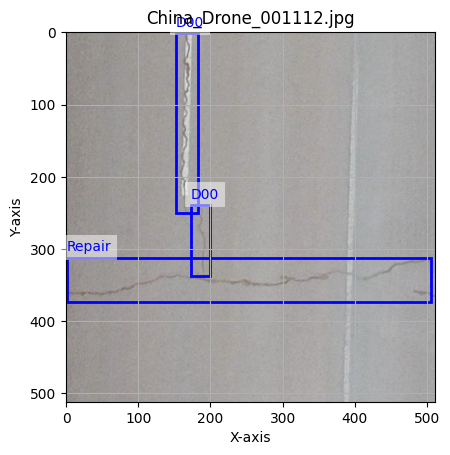

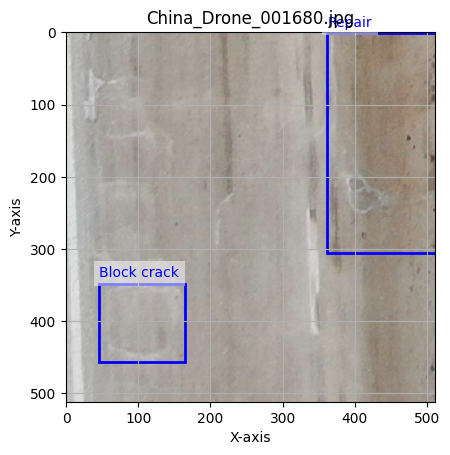

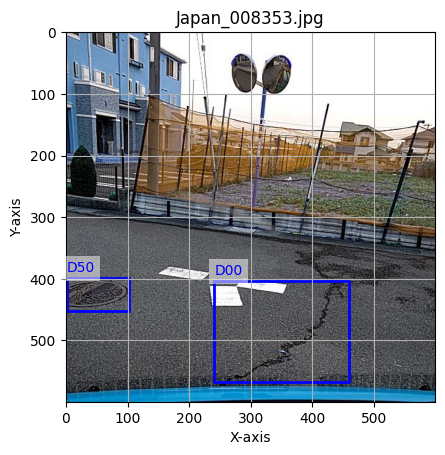

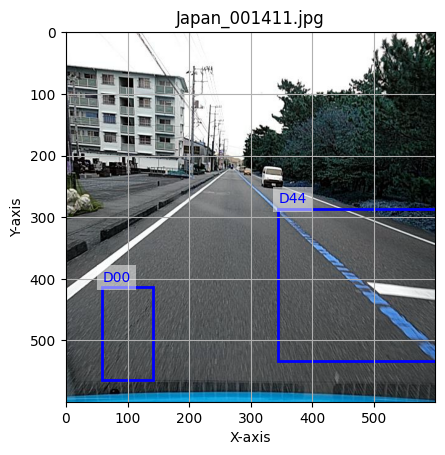

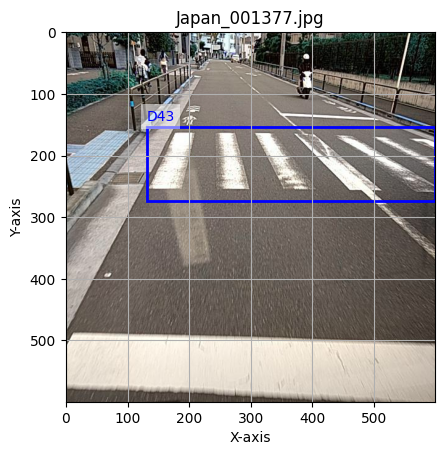

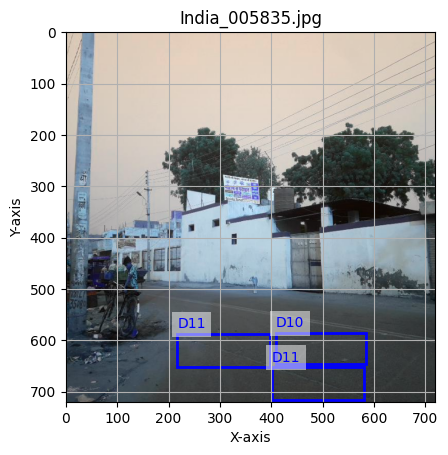

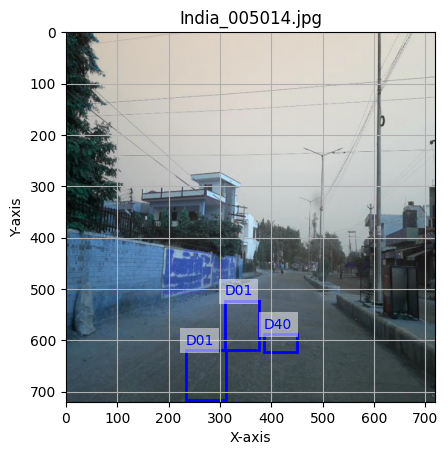

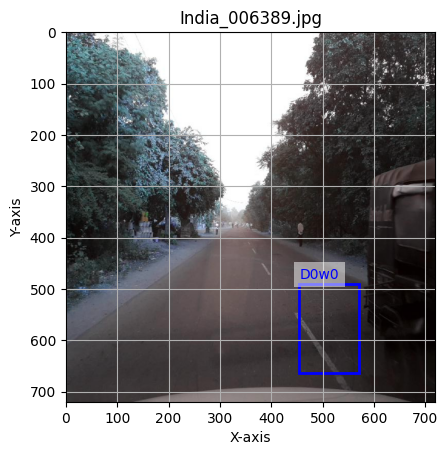

In [55]:
for name in trial["images"]:
    show_img(name,_allXML)

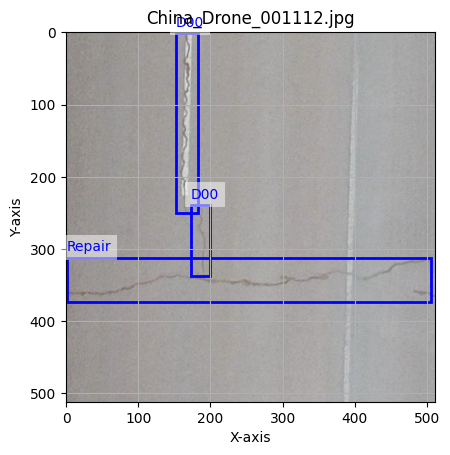

In [6]:
#   PROBLEM 1   ->  USING KNN - HEIRITAGE TO DEFINE THE VALUE !
show_img("China_Drone_001112.jpg",_allXML)

In [32]:
#   COLLECT ALL TYPE OF DATA WHEN WE HAVE COLLECTED    
TYPE = ["D00","D10","D20","D40"]

In [35]:
def get_xml(file_name,dest_dir): 

    _type = file_name.split('_')[0]

    _next = file_name.split('_')[1]
    if _type == "China" or _type == "United":
        _type = _type + '_' + _next
    path = f"Collect_File/{_type}/train/annotations/xmls/{file_name}.xml"
    tree = ET.parse(path)
    h = int(tree.find("size").find("height").text) 
    w = int(tree.find("size").find("width").text)
    converted_files = []
    result = []

    for obj in tree.findall("object"):
        _type = obj.find("name").text
        if _type in TYPE:
            bbox = obj.find("bndbox")

            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            x_center = (float(xmin + xmax) / 2) / w
            y_center = (float(ymin + ymax) / 2) / h
            ws = (xmax - xmin) / w
            hs = (ymax - ymin) / h

            result.append(f"{TYPE.index(_type)} {x_center} {y_center} {ws} {hs}")

            converted_file = os.path.join(dest_dir, f"{file_name}.txt")
            
            with open(converted_file, "w", encoding="utf-8") as f:
                f.write("\n".join(result))

            converted_files.append(converted_file)
        
    return converted_files

def get_img_path(file_name):
    _type = file_name.split('_')[0]
    _next = file_name.split('_')[1]
    if _type == "China" or _type == "United":
        _type = _type + '_' + _next
    path = f"Collect_File/{_type}/train/images/{file_name}"
    return path

**FILE FORMAT**
|   IMAGE
|     |     China_... .jpg
|     |     China_... .jpg 
|   LABELS
|     |     China_... .txt     
|    
|   
|     
|


In [36]:
#   ONLY RUN 1, CREATE FILE 
input_dir = "Collect_Data"
os.makedirs(input_dir)
os.makedirs(os.path.join(input_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "val"), exist_ok=True)

In [38]:
#   Using sklearn elements for train_valid_test split
import sklearn 
from sklearn.model_selection import train_test_split
import pandas as pd

In [39]:
#   Shuffle The Data 
_allXML["detect"] = [[x for x in inner_list if x["type"] in TYPE] for inner_list in _allXML["detect"]]
print(len(_allXML["detect"]))

Data_df = pd.DataFrame({
        "file_name": _allXML["file_name"],
        "images": _allXML["images"],
        "height": _allXML["height"],
        "width": _allXML["width"],
    })

Label_df = _allXML["detect"]

38385


In [40]:
X_train, X_test, y_train, y_test = train_test_split(Data_df,Label_df,test_size=0.2,shuffle=True,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1, shuffle=True,random_state=42) 
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

27637
27637
3071
3071
7677
7677


In [41]:
#   Add To Test
dest_dir = os.path.join("./Collect_Data", "labels", "train")
print(dest_dir)

for idx,row in X_train.iterrows(): 
    get_xml(row["images"].split('.')[0],dest_dir)

./Collect_Data/labels/train


In [42]:
dest_dir = os.path.join("./Collect_Data", "la", "anno")
print(dest_dir)

for idx,row in X_test.iterrows(): 
    get_xml(row["images"].split('.')[0],dest_dir)

./Collect_Data/la/anno


FileNotFoundError: [Errno 2] No such file or directory: './Collect_Data/la/anno/Norway_006538.txt'

In [44]:
dest_dir = os.path.join("./Collect_Data", "labels", "val")
print(dest_dir)

for idx,row in X_val.iterrows(): 
    get_xml(row["images"].split('.')[0],dest_dir)

./Collect_Data/labels/val


In [43]:
#add all pictures 
import shutil

dest_dir = os.path.join("./Collect_Data", "images", "train")
print(dest_dir)

for idx,row in X_train.iterrows(): 
    shutil.move(get_img_path(row["images"]),dest_dir) 

dest_dir = os.path.join("./Collect_Data", "images", "val")
print(dest_dir)

for idx,row in X_val.iterrows(): 
    shutil.move(get_img_path(row["images"]),dest_dir) 

# dest_dir = dest_dir = os.path.join("./Collect_Data", "test", "image")
# print(dest_dir)

# for idx,row in X_test.iterrows(): 
#     shutil.move(get_img_path(row["images"]),dest_dir) 



./Collect_Data/images/train
./Collect_Data/images/val


**DATA AUGMENT** (USING DEEP AUGEMNT TO DETECT BEST TYPE FOR AUGMENT DATA)

In [57]:
!{sys.executable} -m pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:0010.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.4/632.4 kB 6.8 MB/s eta 0:00:00


**MODEL PHRASE**

In [46]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
#check for GPUs
import subprocess
import platform
import sys

print(platform.processor())
if platform.system() == "Darwin":
  if "arm" in platform.processor():
    try:
      subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow-macos"])
      subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow-metal"])
      print("Successfully installed tensorflow-macos and tensorflow-metal.")
        
    except subprocess.CalledProcessError as e:
      print("An error occurred during installation:", e)


import tensorflow as tf

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

arm
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


/Users/tami/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [47]:
pip install ultralytics supervision roboflow

  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 9.4 MB/s eta 0:00:00m eta 0:00:010:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 9.8 MB/s eta 0:00:000m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 10.8 MB/s eta 0:00:0031m11.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 9.7 MB/s eta 0:00:000m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:000m et

In [49]:
import torch
device = torch.device("cuda")

In [50]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.55 🚀 Python-3.9.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)
Setup complete ✅ (8 CPUs, 31.1 GB RAM, 65.4/226.2 GB disk)


In [51]:
torch.backends.mps.is_available()

False

In [ ]:
# DEMO CODE
input_dir = "Collect_Data_mini"
os.makedirs(input_dir)
os.makedirs(os.path.join(input_dir, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "images", "val"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "train"), exist_ok=True)
os.makedirs(os.path.join(input_dir, "labels", "val"), exist_ok=True)

In [ ]:
# ONLY USE FOR DEMO 
X_train, X_test, y_train, y_test = train_test_split(Data_df,Label_df,test_size=0.9,shuffle=True,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,shuffle=True,random_state=42) 

In [37]:
dest_dir = os.path.join("./Collect_Data_mini", "labels", "train")
print(dest_dir)

for idx,row in X_train.iterrows(): 
    get_xml(row["images"].split('.')[0],dest_dir)

dest_dir = os.path.join("./Collect_Data_mini", "labels", "val")
print(dest_dir)

for idx,row in X_val.iterrows(): 
    get_xml(row["images"].split('.')[0],dest_dir)

./Collect_Data_mini/labels/train
./Collect_Data_mini/labels/val


In [42]:
import shutil

dest_dir = os.path.join("./Collect_Data_mini", "images", "train")
print(dest_dir)

for idx,row in X_train.iterrows(): 
    shutil.move(get_img_path(row["images"]),dest_dir) 

dest_dir = os.path.join("./Collect_Data_mini", "images", "val")
print(dest_dir)

for idx,row in X_val.iterrows(): 
    shutil.move(get_img_path(row["images"]),dest_dir) 

./Collect_Data_mini/images/train
./Collect_Data_mini/images/val


In [1]:
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [62]:
#   run 
from ultralytics import YOLO

#   Load a model
model = YOLO("yolo11n.pt")

#   Train the model
results = model.train(data="model.yaml", epochs=100, imgsz=640, device = "cuda",close_mosaic=1 ,batch = 32, augment = True, stream_buffer = True, cache = "disk", dropout = 0.3, iou = 0.7, optimizer = 'AdamW', lr0 = 0.001, nms = True)

Ultralytics 8.3.55 🚀 Python-3.9.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=model.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=disk, device=cuda, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=1, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=True, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /home/dscilab-21/Downloads/Capstone-Project---Asphalt-main/Colle


train: 158.2GB disk space required, with 50% safety margin but only 109.4/226.2GB free, not caching images to disk ⚠️
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/dscilab-21/Downloads/Capstone-Project---Asphalt-main/Collect
val: Caching images (16.6GB Disk): 100%|██████████| 3071/3071 [00:00<00:00, 5492


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.15G      2.218       3.06      1.944         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.029      0.224     0.0369     0.0136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.05G      2.112      2.651      1.853         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.276      0.254      0.172     0.0657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.08G      2.042      2.544      1.798         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.283      0.242      0.191     0.0748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       4.9G      2.004      2.458      1.759         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434       0.28       0.26      0.196     0.0789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.89G      1.959      2.392      1.723         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.332        0.3       0.24      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       4.9G      1.924      2.319      1.697         26        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.358      0.323      0.268      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.08G      1.902      2.265      1.672         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.428      0.348       0.33      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       4.9G      1.884      2.219      1.659         51        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.458      0.383      0.366      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.07G      1.872      2.197      1.648         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.456      0.374      0.358      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.89G      1.855       2.17      1.637         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.451      0.394      0.375      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.09G      1.841      2.148      1.626         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.453       0.41      0.386      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.98G      1.835      2.117      1.612         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.491      0.418      0.408      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       5.1G      1.825      2.096      1.605         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.496      0.426      0.418      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.12G      1.812      2.075      1.605         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.509      0.414      0.422      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.89G        1.8      2.053      1.594         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.515      0.432      0.442      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.14G      1.793      2.032      1.584         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.533      0.439      0.448      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.96G      1.783      2.023      1.575         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.535      0.449      0.456      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.12G       1.78      2.011      1.567         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.527       0.45      0.463      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       5.2G      1.775      1.997      1.567         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.539      0.442      0.465      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.11G      1.767      1.977      1.557         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.548      0.457      0.475      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.08G      1.751      1.968      1.554         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.547      0.478      0.486       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/

                   all       3071       4434      0.547      0.468      0.488      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/

                   all       3071       4434      0.557      0.478      0.496      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/

                   all       3071       4434      0.564      0.483      0.503       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.93G      1.731      1.921      1.531         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.572      0.477      0.503      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.93G      1.729      1.906      1.525         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.568      0.482      0.506      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.15G      1.719      1.888       1.52         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.566      0.492       0.51      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       5.1G      1.718      1.884      1.521         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.569      0.489      0.515      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.08G      1.716      1.874      1.514         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.565      0.497      0.518      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.06G       1.72      1.875      1.518         72        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.578       0.49      0.521      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       5.1G       1.71      1.858      1.506         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.579      0.493      0.524      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.08G      1.706      1.842      1.506         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.587      0.496      0.527      0.266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.89G      1.704      1.831      1.504         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.584        0.5      0.527      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.88G      1.695       1.83      1.496         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.572      0.507      0.528      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.08G      1.695      1.827      1.496         48        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.578      0.504       0.53      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       4.9G      1.687      1.813      1.489         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.588      0.506      0.532       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.95G      1.684      1.804      1.491         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.588      0.507      0.533       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.08G      1.687      1.807      1.486         59        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.581      0.508      0.534       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.88G      1.677      1.791      1.479         52        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.581      0.508      0.534      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>

Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>    
Traceback (most recent call last):
self._shutdown_workers()
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    self._shutdown_workers()
        if w.is_alive():  File "/home/dsc

                   all       3071       4434      0.585      0.507      0.535      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.04G      1.673      1.776      1.479         34        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.591      0.503      0.536      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Traceback (most recent call last):     1.743      1.473         94        640:  
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>


Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f29425714c0>Exception ignored in: Traceback (most recent call last):
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/dscilab-21/miniconda3/envs/TaMi/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/home/d

                   all       3071       4434      0.592      0.506      0.537      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.04G      1.667      1.765      1.473         41        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.589      0.508      0.537      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.09G      1.663      1.758      1.473         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.588      0.508      0.538      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.05G      1.657      1.756      1.459         70        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434       0.59      0.507      0.538      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.07G      1.658       1.74      1.464         43        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.594      0.508      0.538      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.07G      1.655       1.74      1.458         38        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434       0.59       0.51      0.539      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.89G      1.643      1.722      1.456         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.593      0.513       0.54      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.04G      1.639      1.705      1.451         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.599      0.511      0.542      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.94G      1.641      1.715       1.45         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.602      0.511      0.543      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.94G      1.639      1.706       1.45         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.605      0.508      0.544      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.92G      1.641      1.704      1.451         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.607      0.508      0.545      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.08G      1.631      1.702      1.447         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.605      0.506      0.545      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.88G      1.634        1.7      1.445         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.607      0.507      0.545      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.89G      1.632      1.681      1.443         64        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.611      0.505      0.546       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       5.1G      1.626      1.673      1.437         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.615      0.506      0.547       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.08G      1.615      1.652      1.431         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.615      0.507      0.547       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.08G      1.615      1.659      1.432         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.612      0.509      0.548      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.99G      1.615      1.656      1.432         87        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.618      0.508      0.549      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.96G      1.614      1.652      1.431         45        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621      0.506       0.55      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.92G      1.611      1.646      1.425         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.618       0.51       0.55      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.08G      1.612      1.651      1.427         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.617       0.51      0.552      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.07G      1.603      1.636       1.42         55        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434       0.62      0.507      0.552      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.13G      1.606      1.636       1.42         49        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.624      0.506      0.553      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.04G      1.602      1.627      1.417         62        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.622      0.509      0.554      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.17G      1.605       1.63       1.42         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.615      0.518      0.556      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.89G      1.594      1.618      1.411         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434       0.62      0.514      0.557      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.08G      1.585       1.61      1.409         54        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621      0.515      0.558      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       5.1G      1.591      1.603      1.412         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.616      0.517      0.558      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.11G      1.589      1.597      1.405         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.619      0.516      0.558      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.08G      1.588      1.598      1.407         40        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621      0.517      0.559      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.08G      1.581      1.589      1.404         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621       0.52       0.56      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.04G      1.576      1.575      1.397         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621      0.521       0.56      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.09G      1.582      1.575      1.399         50        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.619      0.519       0.56      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.05G      1.575       1.57      1.395         28        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621       0.52      0.561      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.07G      1.579      1.577      1.397         66        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.622      0.521      0.562       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.95G      1.575      1.569      1.398         63        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.621      0.521      0.563       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.89G      1.564      1.559      1.394         30        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.629      0.519      0.565       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.07G       1.56      1.554      1.395         36        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.629      0.518      0.565       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.89G       1.57      1.556      1.392         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.633      0.516      0.566      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.92G      1.556      1.538      1.382         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.628       0.52      0.567      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.05G       1.56       1.54      1.386         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.632      0.521      0.568      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       5.1G      1.558      1.536      1.383         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.632      0.521      0.568      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.04G      1.554      1.539      1.382         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.633      0.521      0.568      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.06G      1.552      1.539      1.383         60        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.629      0.523      0.568      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.12G      1.547      1.515      1.378         78        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.633      0.523       0.57      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.08G       1.55      1.522      1.379         56        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.632      0.522       0.57      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.05G      1.545      1.519      1.377         32        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.638      0.522      0.571      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.89G      1.542      1.511      1.374         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.639      0.522      0.571      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.94G      1.546       1.51      1.374         74        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.642       0.52      0.571      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.88G      1.543      1.516      1.374         75        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.645      0.518      0.572      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.14G      1.533      1.501       1.37         79        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.649      0.518      0.573      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.88G      1.532       1.49      1.371         44        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.649      0.518      0.573      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.14G       1.53      1.489      1.366         53        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.649      0.517      0.573      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.88G      1.531      1.491      1.368         47        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.648      0.516      0.573      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.07G      1.528      1.485      1.368         58        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.648      0.517      0.574      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.88G      1.529      1.487      1.367         46        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.645       0.52      0.574      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.88G      1.525      1.485      1.364         61        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.642      0.521      0.574      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       5.1G      1.528       1.48      1.364         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.644      0.519      0.574      0.294
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.88G       1.54      1.425      1.407         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.644      0.521      0.575      0.294

100 epochs completed in 5.194 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 5.5MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.9.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7974MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       3071       4434      0.593      0.535      0.564      0.297
                   D00       1087       2112      0.596      0.528      0.555      0.315
                   D10        633        969      0.581      0.531      0.554      0.284
                   D20        670        812      0.628      0.663      0.691      0.389
                   D40        301        541      0.568      0.416      0.455        0.2
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train8


In [45]:
results = model("Collect_Data/images/val/China_Drone_000003.jpg")


image 1/1 /Users/tami/Documents/Đồ Án/Capstone-Project---Asphalt-Detection/Collect_Data/images/val/China_Drone_000003.jpg: 640x640 1 D00, 1 D10, 115.9ms
Speed: 8.5ms preprocess, 115.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


In [46]:
for result in results:
    boxes = result.boxes 
    masks = result.masks  
    keypoints = result.keypoints  
    probs = result.probs  
    obb = result.obb  
    result.show()  
    # result.save(filename="result.jpg")  


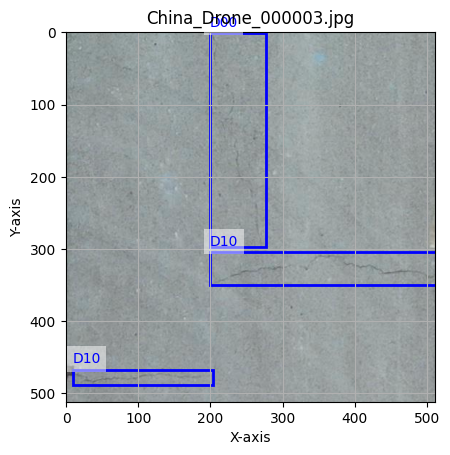

In [8]:
show_img("China_Drone_000003.jpg",_allXML)

In [64]:
%matplotlib inline

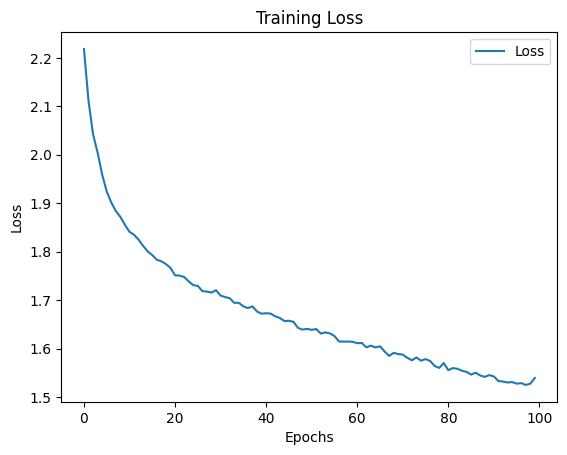

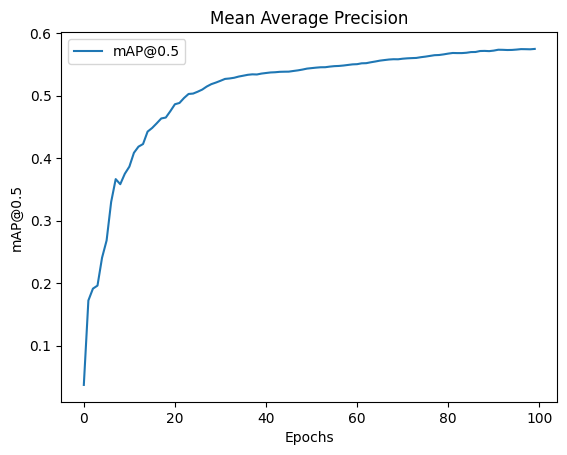

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Load training results
results = []
path = "runs/detect/train8/results.csv"

results = pd.read_csv(path)

epochs = range(len(results['metrics/mAP50(B)']))
loss = results['train/box_loss']
map50 = results['metrics/mAP50(B)']

plt.figure()
plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, map50, label='mAP@0.5')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5')
plt.title('Mean Average Precision')
plt.legend()
plt.show()

In [67]:
results['F1_score'] = 2 * (results['metrics/precision(B)'] * results['metrics/recall(B)']) / (results['metrics/precision(B)'] + results['metrics/recall(B)'])

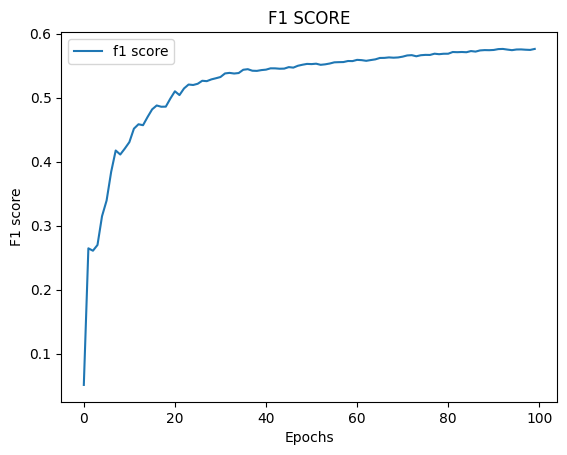

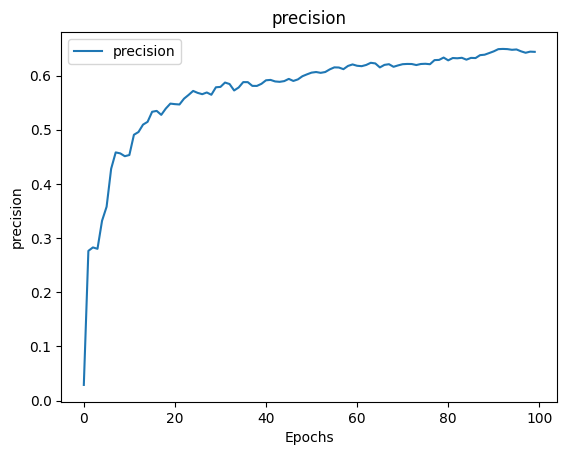

0.64818
0.64472
0.64208
0.64415
Final F1 score archived after the Val: 0.64376


In [74]:
f1 = results["F1_score"]
plt.figure()
plt.plot(epochs, f1, label='f1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.title('F1 SCORE')
plt.legend()
plt.show()

f1 = results["metrics/precision(B)"]
plt.figure()
plt.plot(epochs, f1, label='precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.title('precision')
plt.legend()
plt.show()

for i in range(95,99): 
    print(f1[i]) 

print(f"Final F1 score archived after the Val: {f1[99]}")

In [48]:
import torchvision 
# from torchvision import FasterRCNN_ResNet50_FPN_Weights

In [ ]:
nd_model = torchvision.models.detection.fasterrcnn_resnet50_fpn()

nd_model.train()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/tami/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.1MB/s]


In [52]:
in_features = nd_model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

1024
